In [4]:
# Importing necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

plt.style.use('ggplot')

# Exploring Data

In [5]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


# Data Validation

This data set has 947 rows, 8 columns. I have validated all features and I have made changes by following:
- `recipe`: Numeric values without missing values. No need to clean
- `calories`,`carbohydrate`,`sugar` and `protein`: Numeric values with 52 missing values in the same rows (~5% of total rows). I decided to drop these rows.
- `category`: 11 categories without missing values. There is `Chicken Breast` category which not in the 10 possible values list. Droping this value is needed.
- `servings`: Categorical values without missing values. Converting to numerical values is needed
- `high_traffic`: Changed column format to binary which `1` means that when the recipe was shown, the traffic to the site was high and `0` was not.

After the changes, The data set has 801 rows left (-15%).

In [7]:
# Investigate missing values
df.isna().sum().rename('# of NA')

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
Name: # of NA, dtype: int64

In [8]:
df['recipe'].nunique()

947

In [9]:
ten_possible_value = {'Lunch/Snacks', 'Beverages', 'Potato','Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'}
print(set(df['category'].unique()) - ten_possible_value, 'is out of the possible values.')

{'Chicken Breast'} is out of the possible values.


In [10]:
df[df['category'] == 'Chicken Breast'].shape

(98, 8)

In [11]:
# Drop rows where category is 'Chicken Breast'
df = df[df['category'] != 'Chicken Breast']

In [12]:
# Drop rows having missing values
df.dropna(subset=['calories','carbohydrate','sugar','protein'], inplace=True)

In [13]:
df['servings'].value_counts()

servings
4               326
6               165
2               158
1               149
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [14]:
df[df['servings'].isin(['6 as a snack' , '4 as a snack'])]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


In [15]:
# Convert to numeric
df['servings'] = df['servings'].str.replace(' as a snack','')
df['servings'] = df['servings'].astype(int)

In [16]:
df['servings'].value_counts()

servings
4    328
6    166
2    158
1    149
Name: count, dtype: int64

In [17]:
# Target feature
# Changes type format to Binary
df['high_traffic'] = df['high_traffic'].fillna(0).replace('High',1)

In [18]:
df.shape

(801, 8)

In [19]:
df.isna().sum().rename('# of NA')

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
Name: # of NA, dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        801 non-null    int64  
 1   calories      801 non-null    float64
 2   carbohydrate  801 non-null    float64
 3   sugar         801 non-null    float64
 4   protein       801 non-null    float64
 5   category      801 non-null    object 
 6   servings      801 non-null    int64  
 7   high_traffic  801 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 56.3+ KB


# Exploratory Analysis

## Target feature - high_traffic
Since we need to predict which recipes will lead to high traffic, high_traffic would be our target feature. The ratio of 1 to 0 is approximately 61 to 39 percent.

In [21]:
df['high_traffic'].value_counts(normalize=True)

high_traffic
1    0.612984
0    0.387016
Name: proportion, dtype: float64

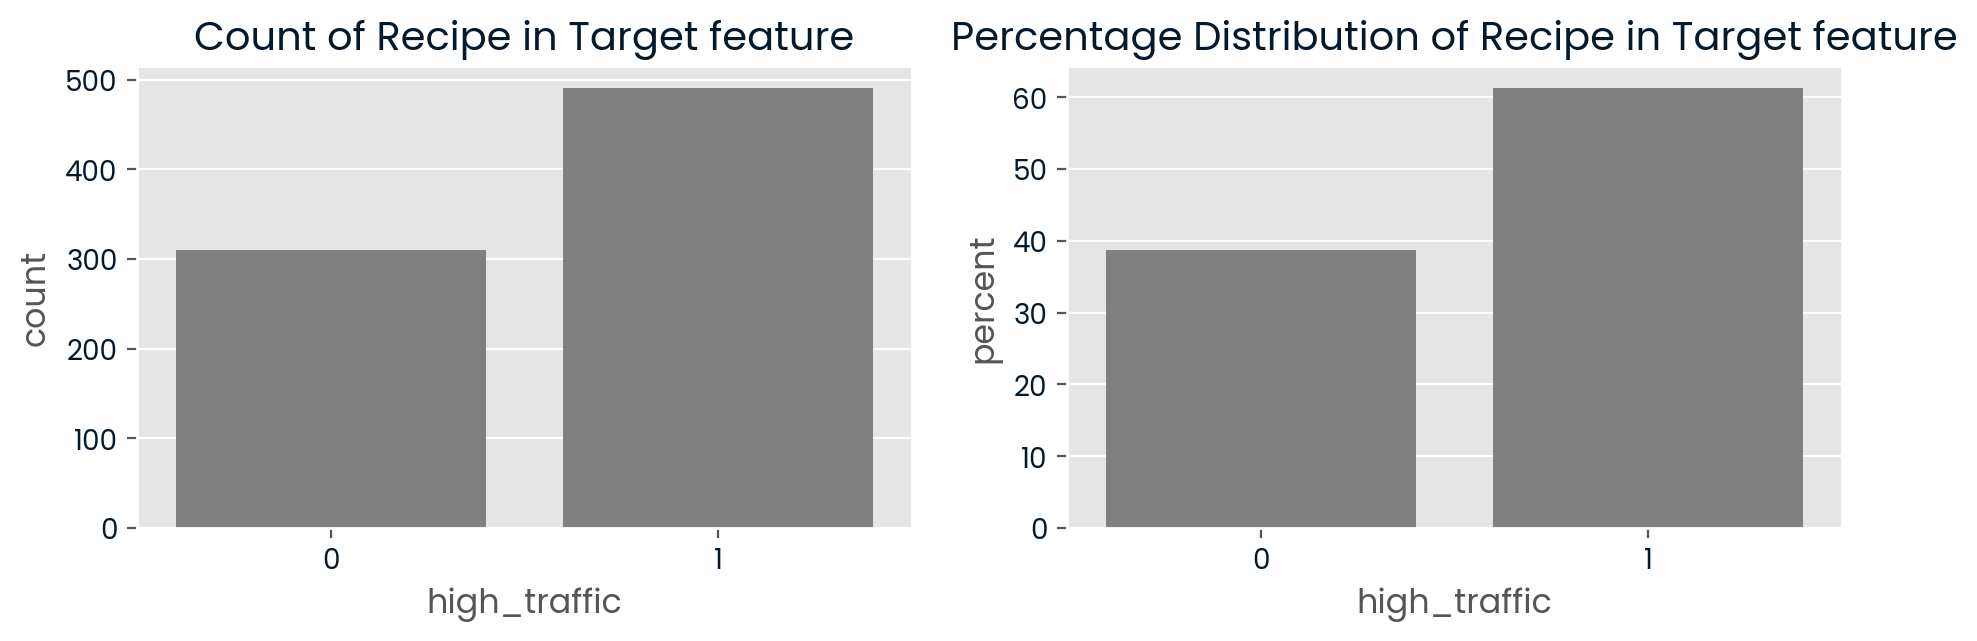

In [22]:
fig, axes = plt.subplots(1,2,figsize=(11,3))
sns.countplot(x='high_traffic', data=df, ax=axes[0], color='gray').set(title='Count of Recipe in Target feature')
sns.countplot(x='high_traffic', data=df, stat='percent', ax=axes[1], color='gray').set(title='Percentage Distribution of Recipe in Target feature')
plt.show()

## Numeric features - calories, carbohydrate, sugar, protein
From the heatmap below, we can conclude that all pairs of features are having a weak linear relationship.

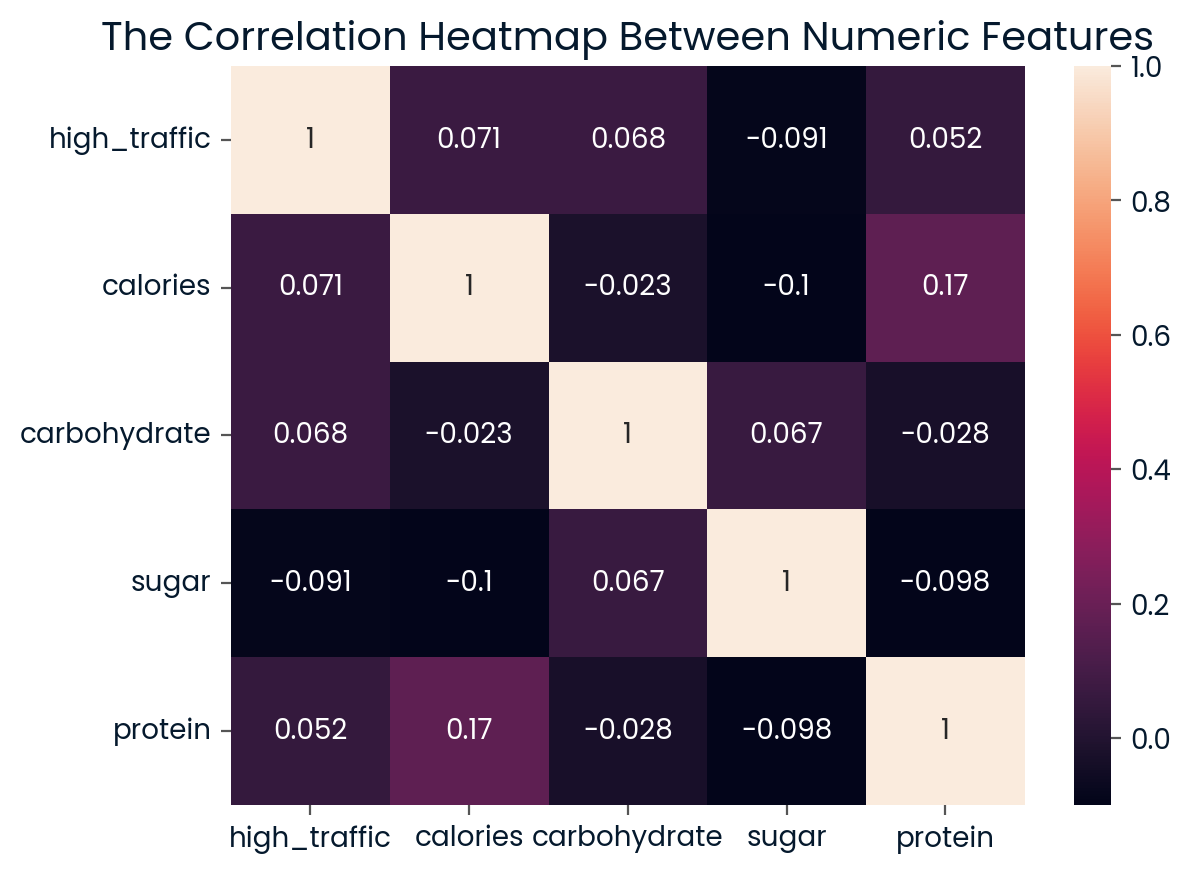

In [23]:
sns.heatmap(df[['high_traffic','calories','carbohydrate','sugar','protein']].corr(), annot=True).\
set(title='The Correlation Heatmap Between Numeric Features')
plt.show()

To spot the non-linear relationship, I decided to make scatterplot to further investigate the relationship between the numeric features and I found out there is no trends, clusters, or anomalies in the data.

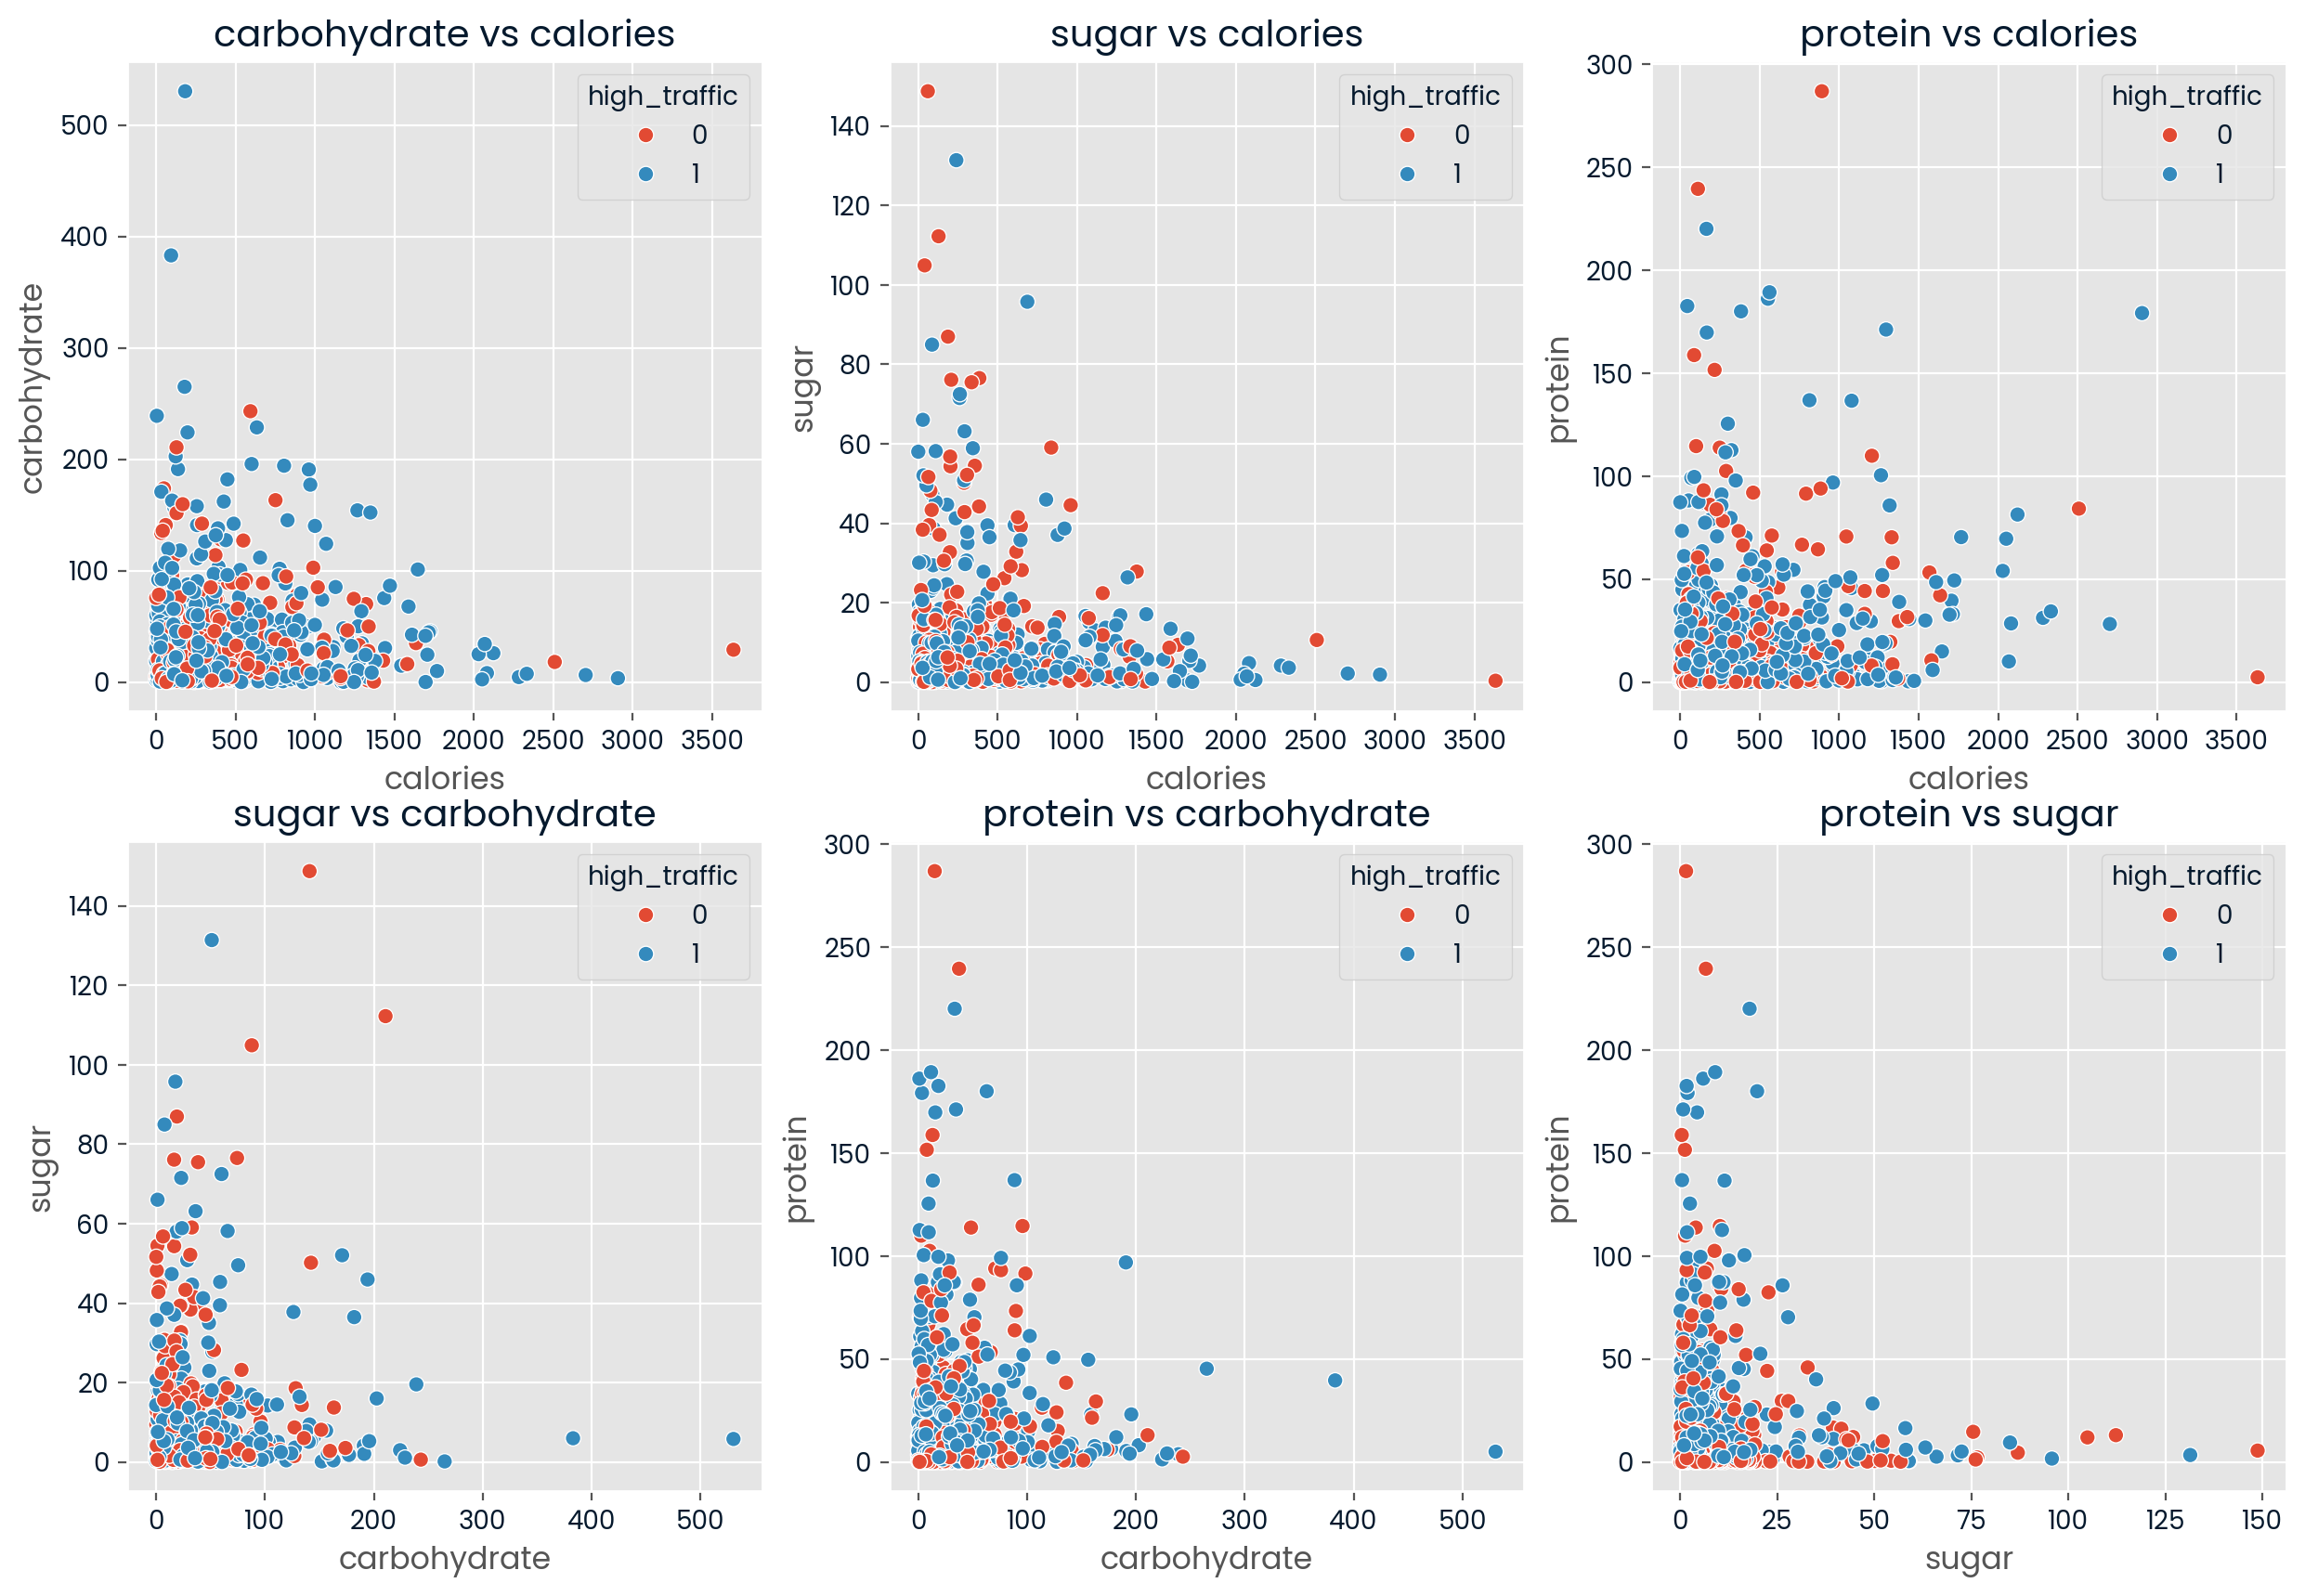

In [24]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
numeric_column = ['calories','carbohydrate','sugar','protein']

n = 0
for i in range(len(numeric_column)-1):
    for j in range(1+i, len(numeric_column)):
        if n < 3:
            ax_ = axes[0,n]
        else:
            ax_ = axes[1,n-3]
        n += 1
        sns.scatterplot(x=numeric_column[i], y=numeric_column[j],hue='high_traffic',data=df, ax=ax_).set(title=f'{numeric_column[j]} vs {numeric_column[i]}')

To spot in particular, I decided to make histogram and we can see all of numeric features have right skew distribution. 

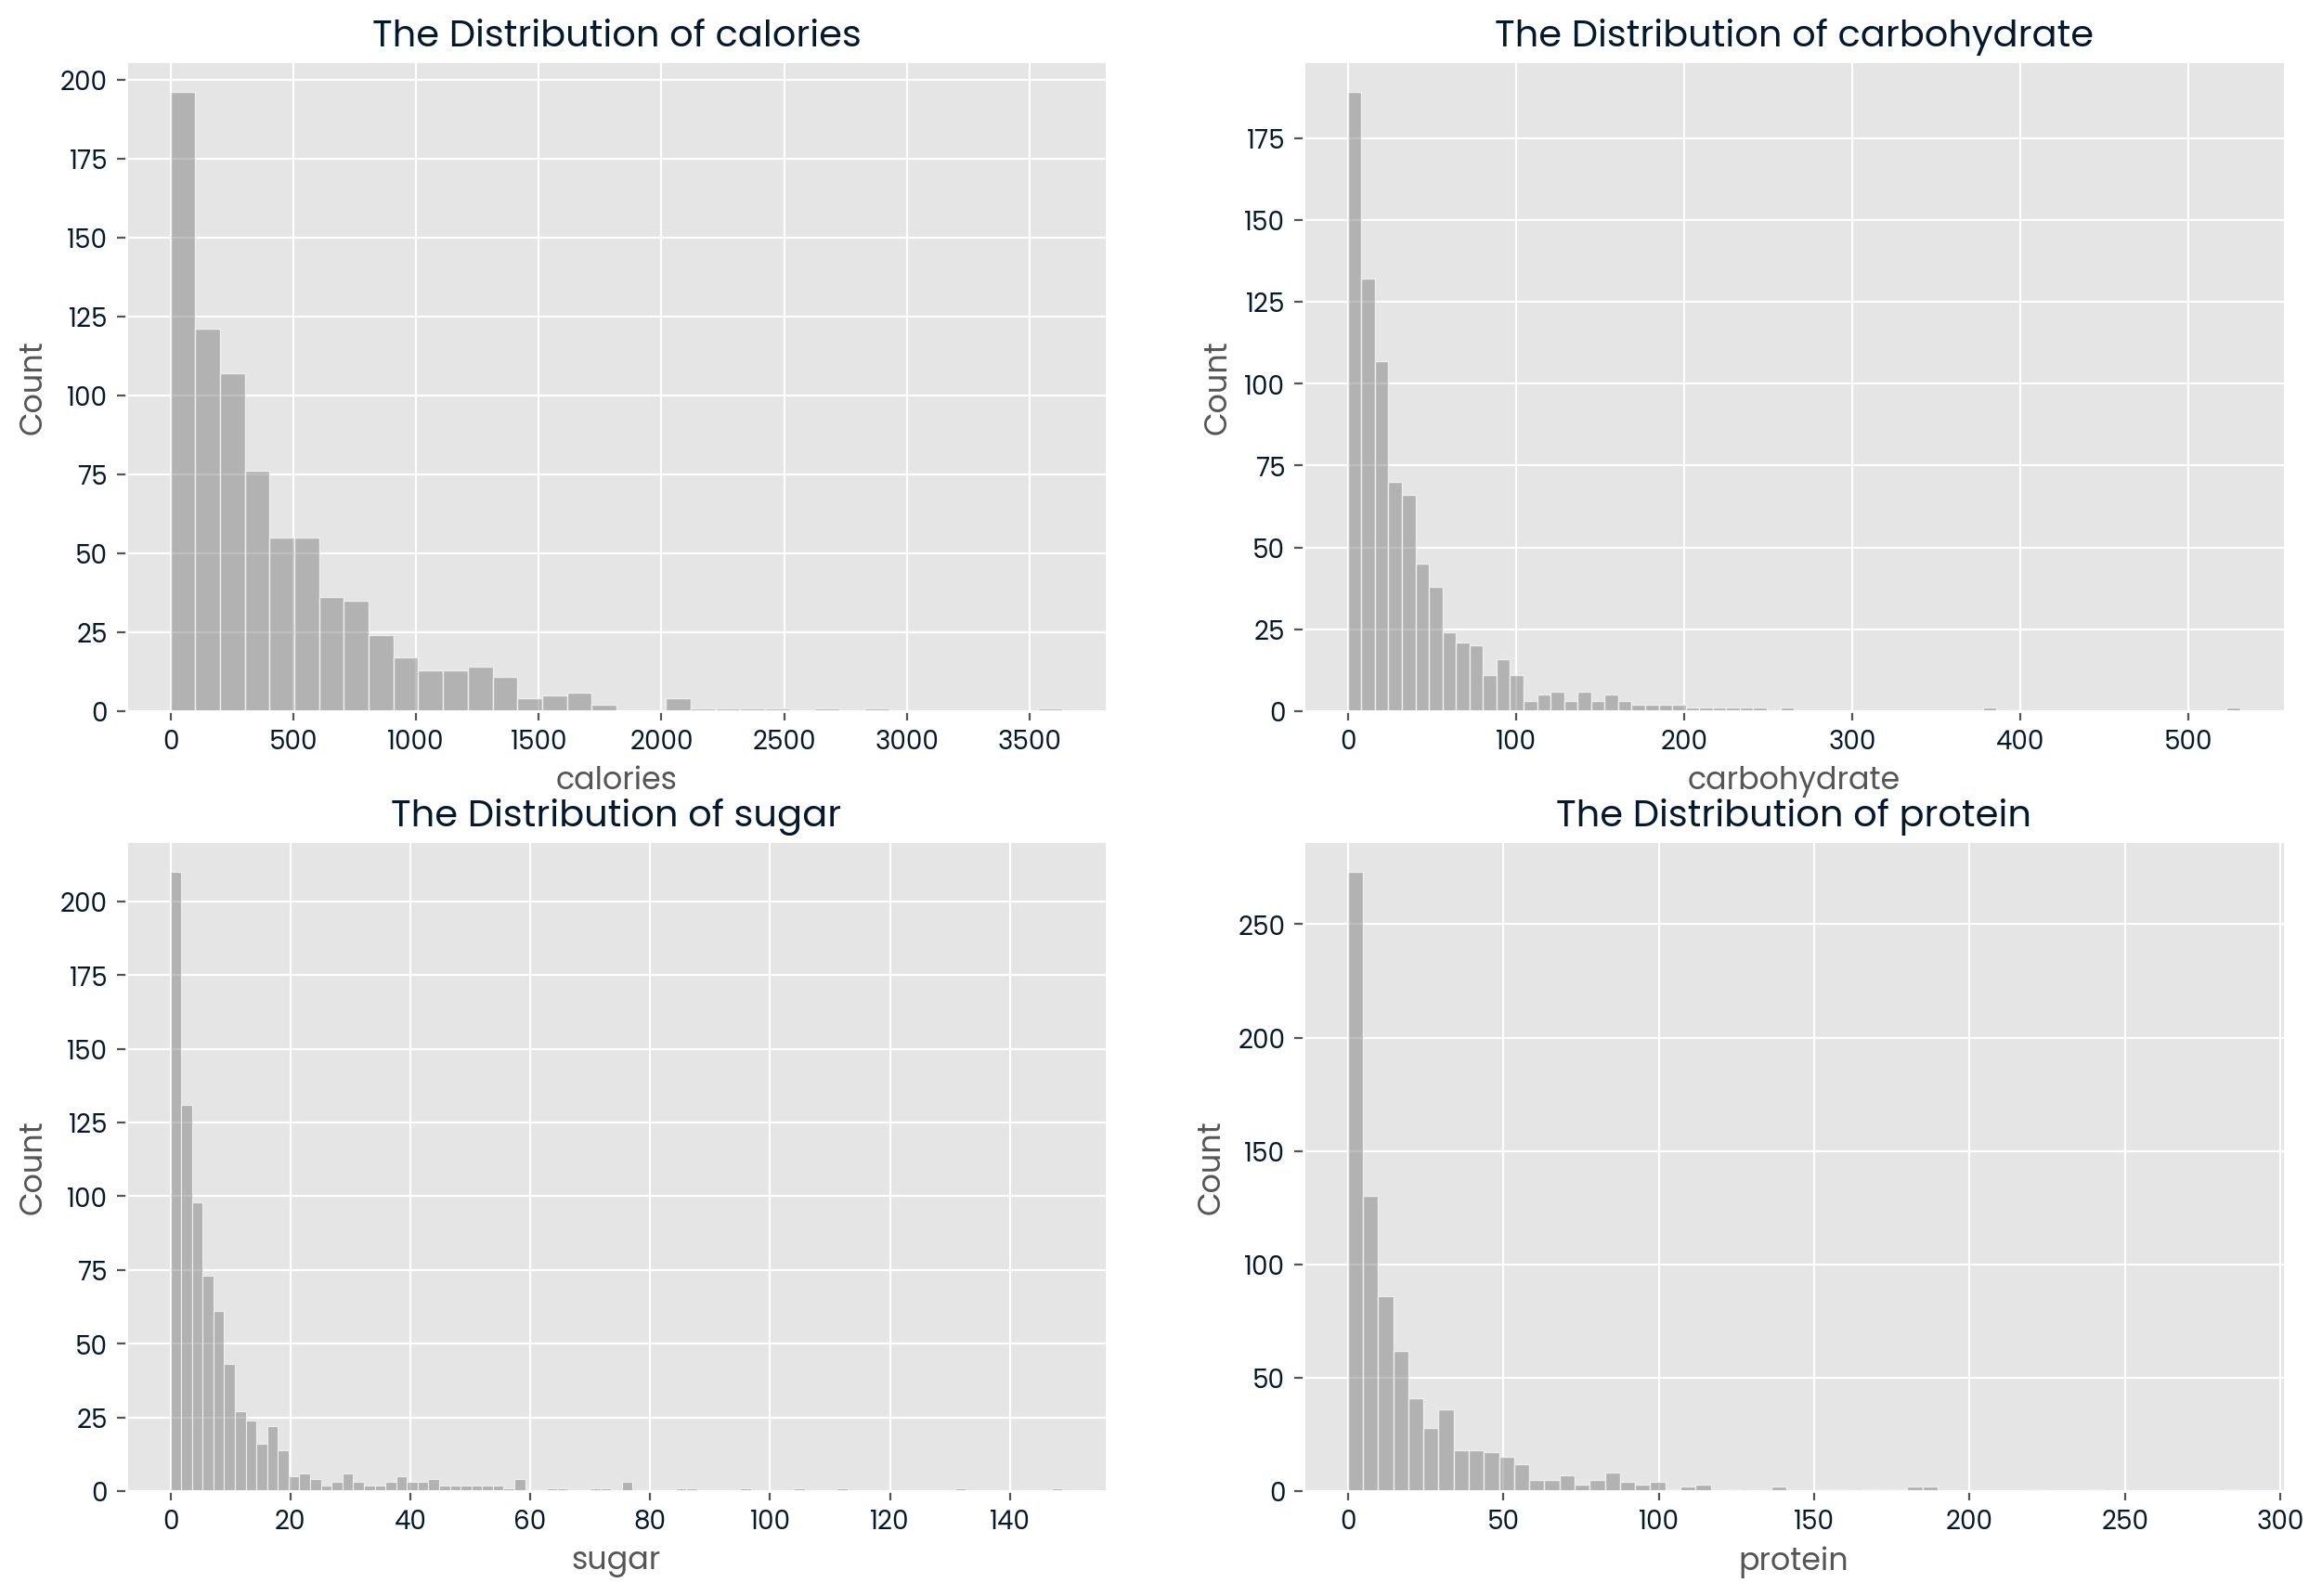

In [25]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
numeric_column = ['calories','carbohydrate','sugar','protein']

n = 0
for i in numeric_column:
    if n < 2:
        ax_ = axes[0,n]
    else:
        ax_ = axes[1,n-2]
    n += 1
    sns.histplot(x=i, data=df, alpha=0.5, ax=ax_, color='gray').set(title=f'The Distribution of {i}')

plt.show()

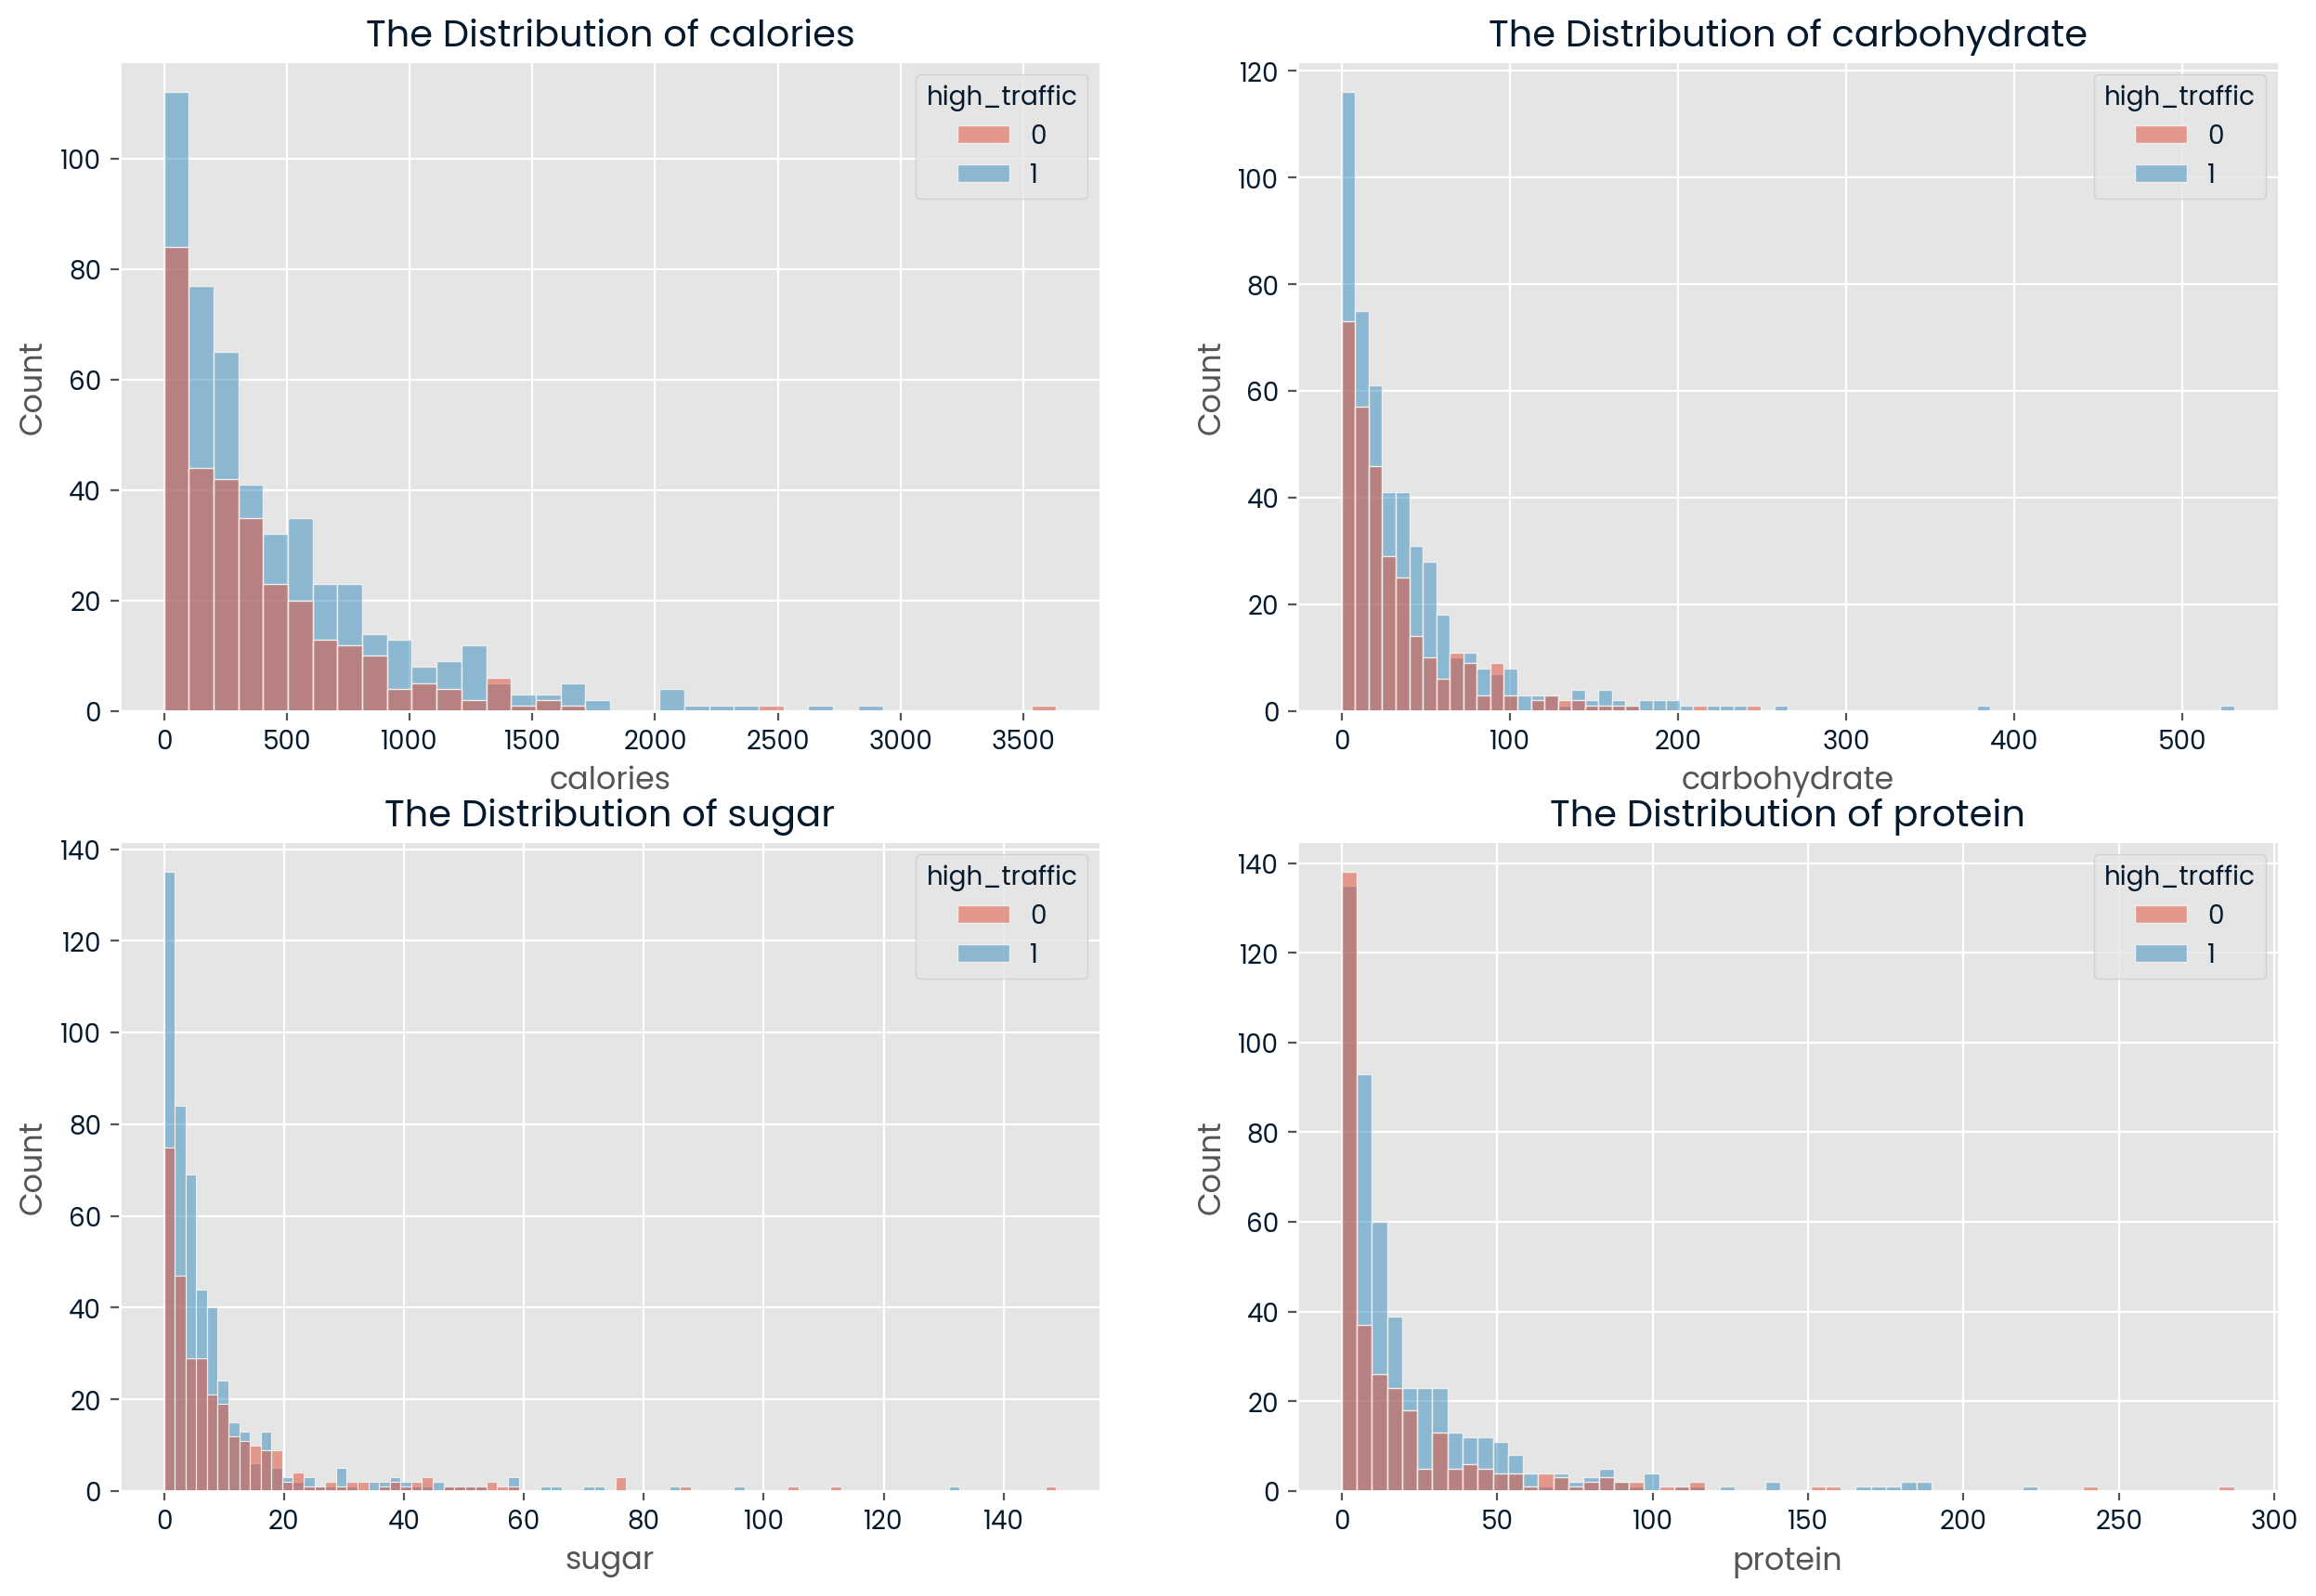

In [26]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
numeric_column = ['calories','carbohydrate','sugar','protein']

n = 0
for i in numeric_column:
    if n < 2:
        ax_ = axes[0,n]
    else:
        ax_ = axes[1,n-2]
    n += 1
    sns.histplot(x=i, data=df, alpha=0.5, ax=ax_, color='gray', hue='high_traffic').set(title=f'The Distribution of {i}')

plt.show()

## Category Variables - servings, category
From the bar charts below, we can see the most frequent in servings and category variables - 4, Breakfast in the dataset.

In [27]:
df['category'].value_counts(normalize=True)

category
Breakfast        0.132335
Beverages        0.114856
Potato           0.103620
Lunch/Snacks     0.102372
Vegetable        0.097378
Dessert          0.096130
Meat             0.092385
Pork             0.091136
Chicken          0.086142
One Dish Meal    0.083645
Name: proportion, dtype: float64

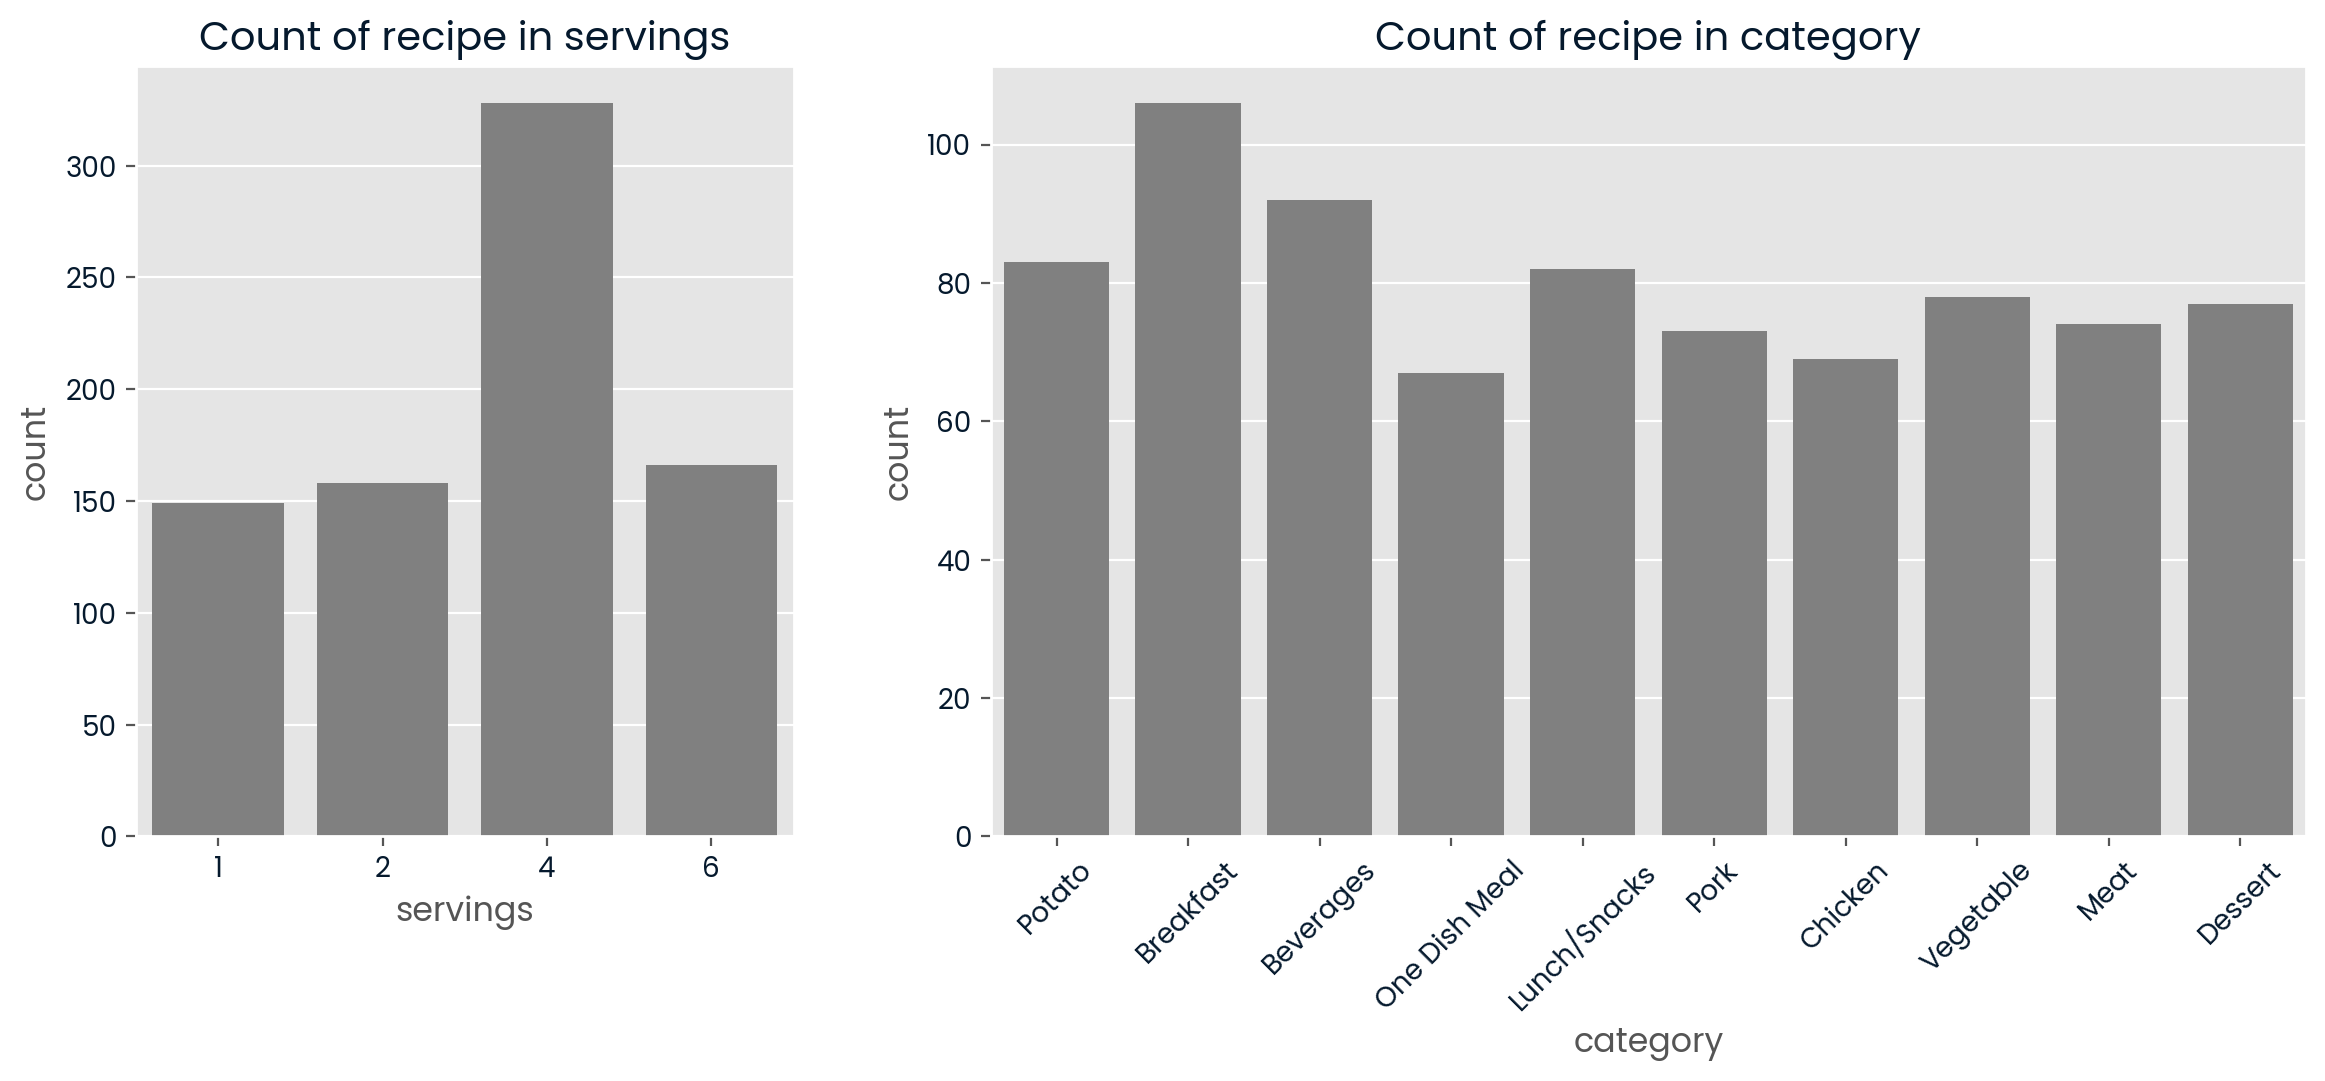

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 5))

# Create a grid with 2 columns, the first column being twice the width of the second
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# Plot data on each subplot
sns.countplot(x='servings', data=df, color='gray', ax=ax0).set(title='Count of recipe in servings')
sns.countplot(x='category', data=df, color='gray', ax=ax1).set(title='Count of recipe in category')

plt.xticks(rotation=45)
plt.show()

### Proportion of target feature
I also investigated proportion of target feature, value of `1`, by servings and category. In servings feature, we can see that the proportion for each value is not strog different; at approximately 60%. In category feature, Vegetable category have the highest proportion and Beverage have the least.

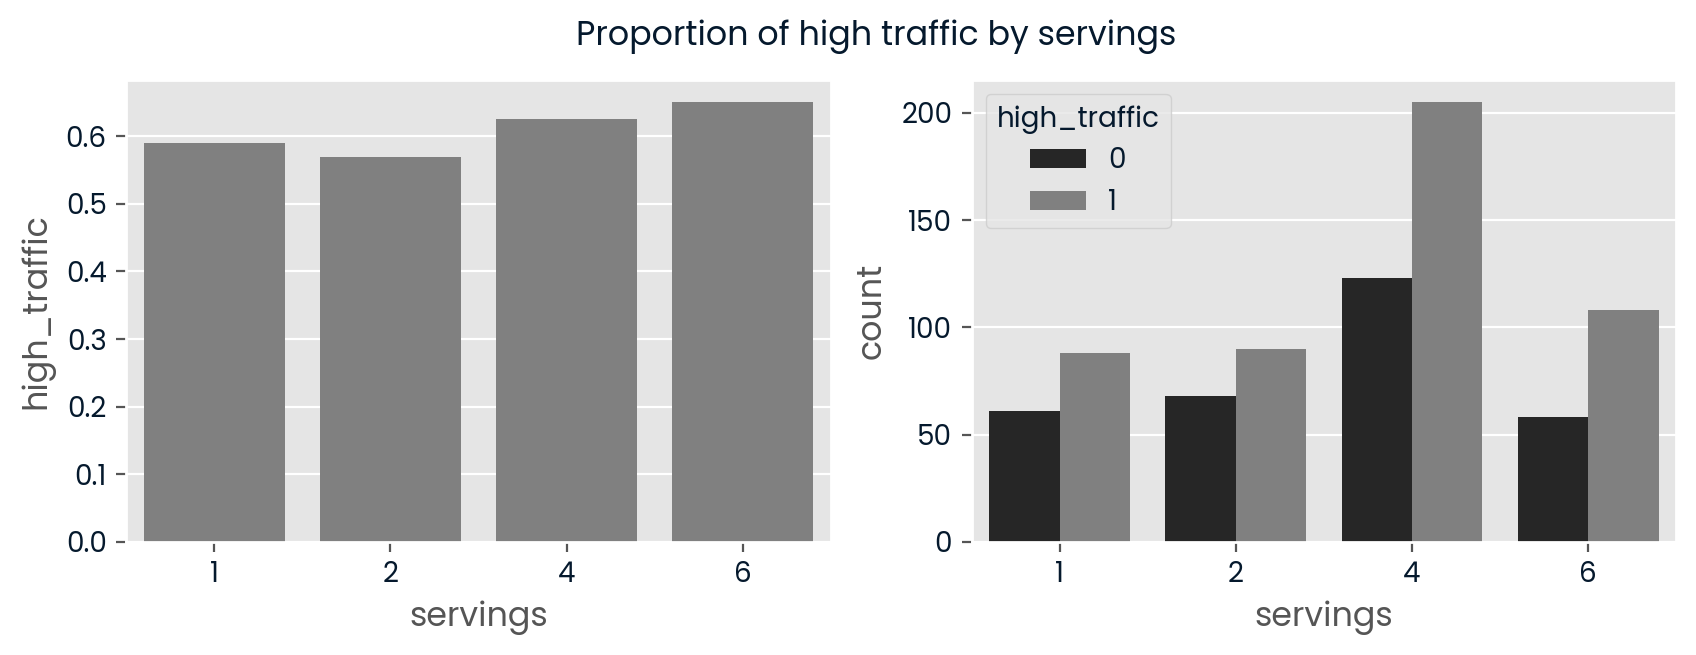

In [29]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Proportion of high traffic by servings')
sns.barplot(x='servings',y='high_traffic', data=df, ax=axes[0], color='gray', ci=None)
sns.countplot(x='servings',hue='high_traffic', data=df, ax=axes[1], color='gray')
plt.show()

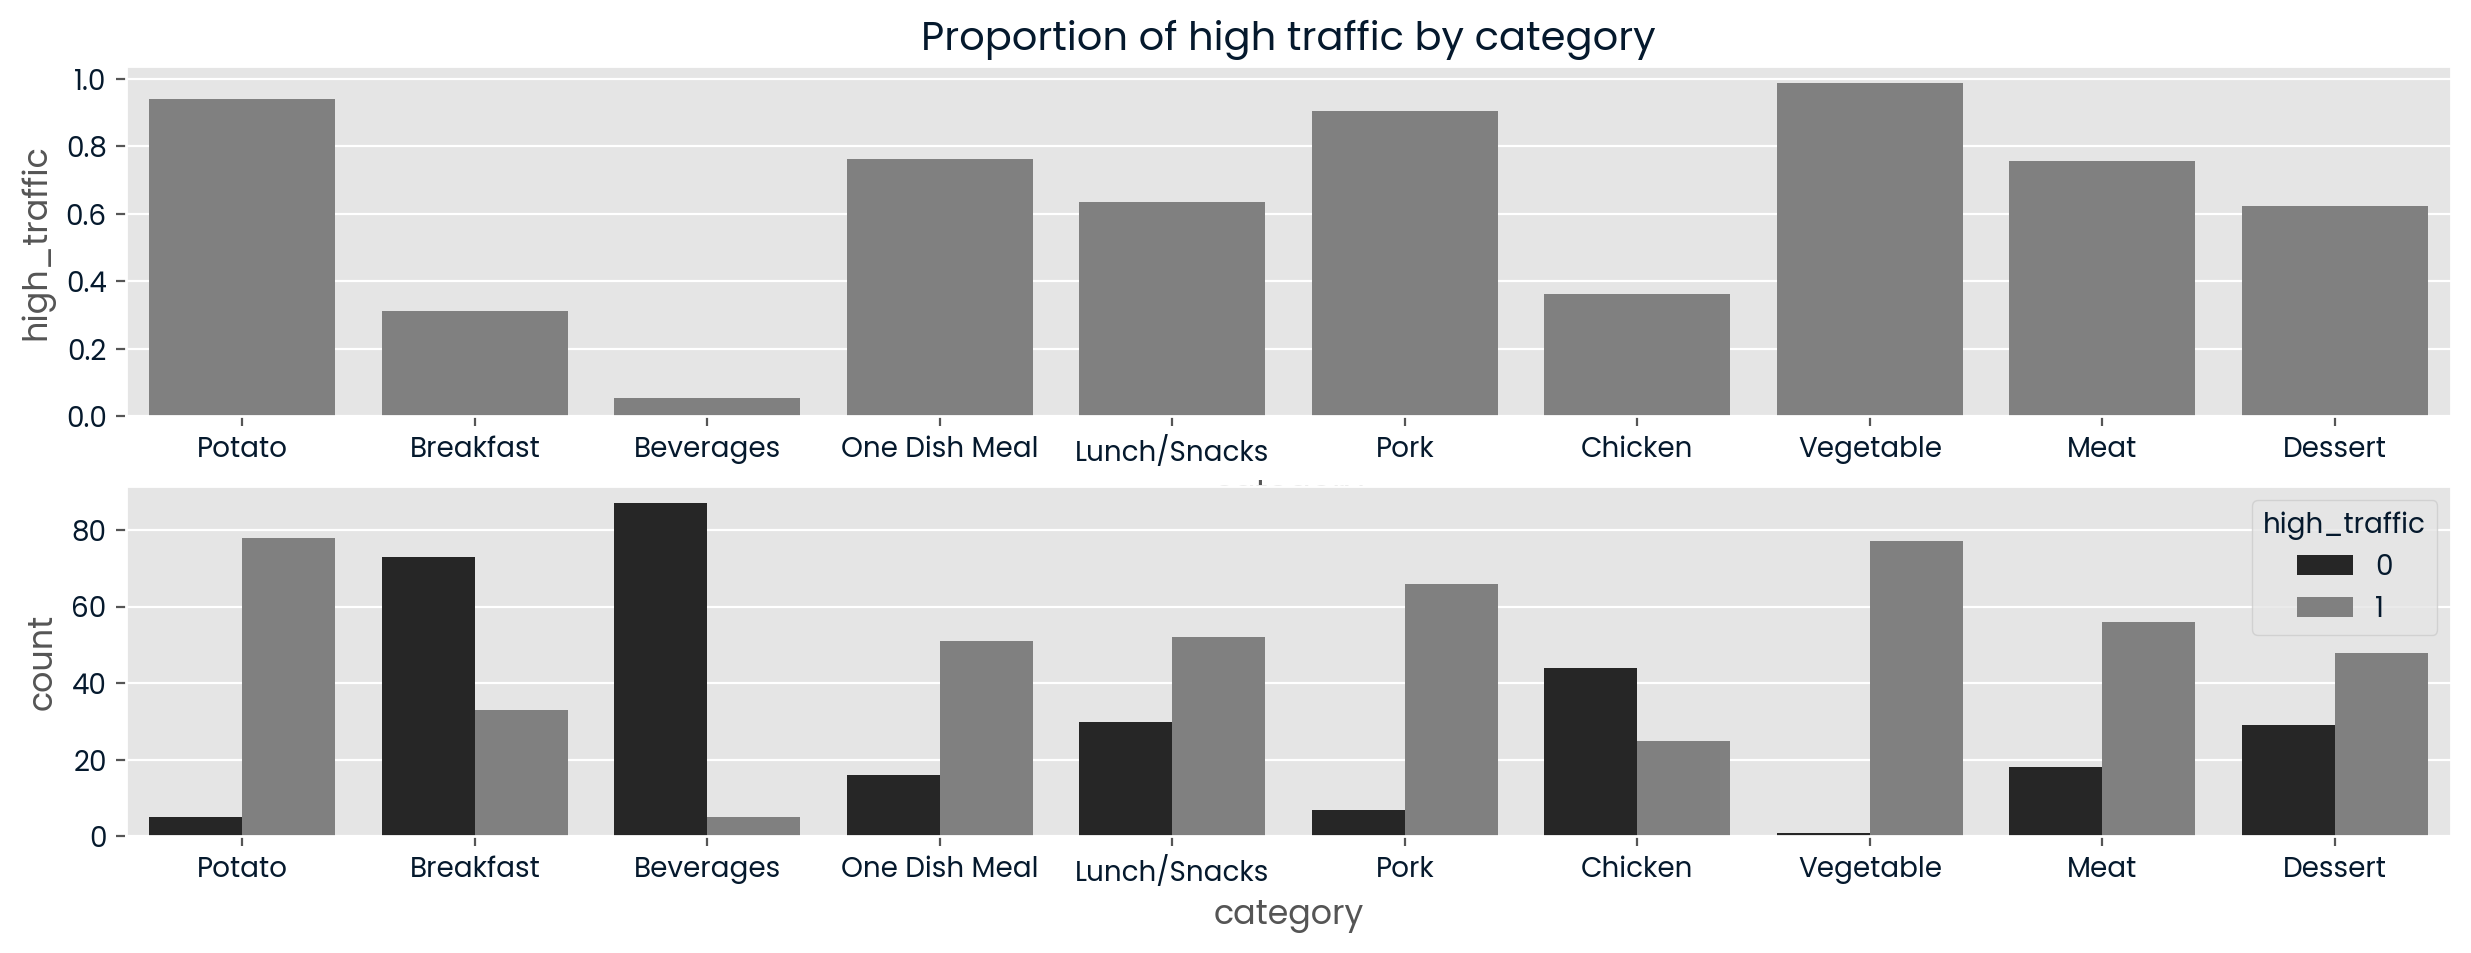

In [30]:
fig, axes = plt.subplots(2,1,figsize=(15,5))
sns.barplot(x='category',y='high_traffic', data=df, ax=axes[0], color='gray', ci=None).set(title='Proportion of high traffic by category')
sns.countplot(x='category',hue='high_traffic', data=df, ax=axes[1], color='gray')
plt.show()

# Model Fitting & Evaluation
Predicting which recipes will lead to high traffic is a classification problem in machine learning. I am choosing the Logistic Regression model because we can see strong to moderate relationship between some features and target feature. The comparison model I am choosing is the Decision Tree Classification model because it is easy to interpret with independence from outliers.

For the evaluation, I am choosing precision and AUC-ROC (Area Under the Receiver Operating Characteristic curve) to evaluate the model. Precision measures the proportion of predicted positive cases that are actually correct. AUC-ROC measures the overall performance of the binary classification model.

## Prepare Data for Modelling
To enable modelling, we chose `calories`, `carbohydrate`, `sugar`, `protein`, `category` and `servings` as features, `high_traffic` as target feature. I also have made the following changes:

- Convert the categorical features into numeric features
- Split the data into a training set and a test set

In [31]:
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

In [32]:
list(zip(range(10),label_encoder.classes_))

[(0, 'Beverages'),
 (1, 'Breakfast'),
 (2, 'Chicken'),
 (3, 'Dessert'),
 (4, 'Lunch/Snacks'),
 (5, 'Meat'),
 (6, 'One Dish Meal'),
 (7, 'Pork'),
 (8, 'Potato'),
 (9, 'Vegetable')]

In [33]:
X = df.drop(['recipe','high_traffic'], axis=1)
y = df['high_traffic']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Logistic Regression Model

In [35]:
logist = LogisticRegression()
logist.fit(X_train, y_train)

LogisticRegression()

In [36]:
y_score = logist.predict_proba(X_test)[:, 1]
y_pred = logist.predict(X_test)
print('Logistic Regression precision_score: ',precision_score(y_test, y_pred))
print('Logistic Regression roc_auc_score:', roc_auc_score(y_test, y_score))

Logistic Regression precision_score:  0.8014184397163121
Logistic Regression roc_auc_score: 0.8646028767979987


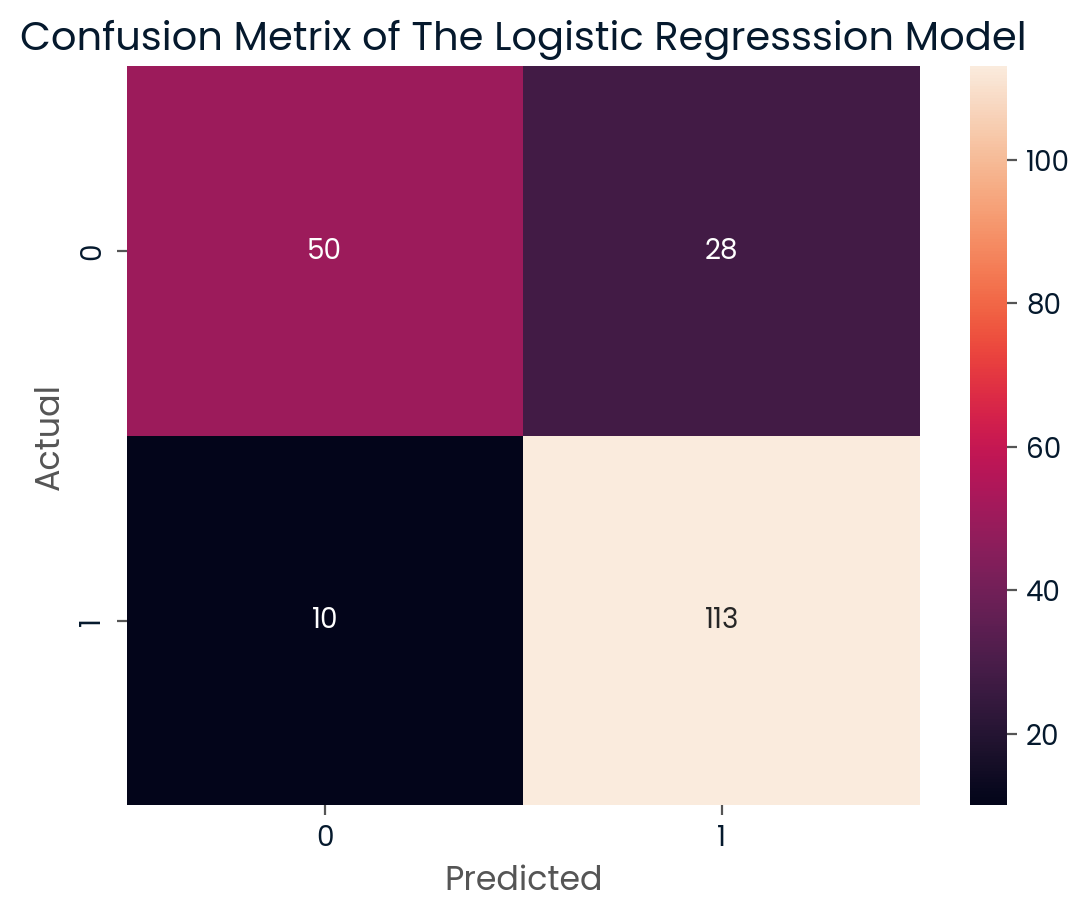

In [37]:
# Assuming y_true and y_pred are the true and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Metrix of The Logistic Regresssion Model')
plt.show()

### Finding the feature importance

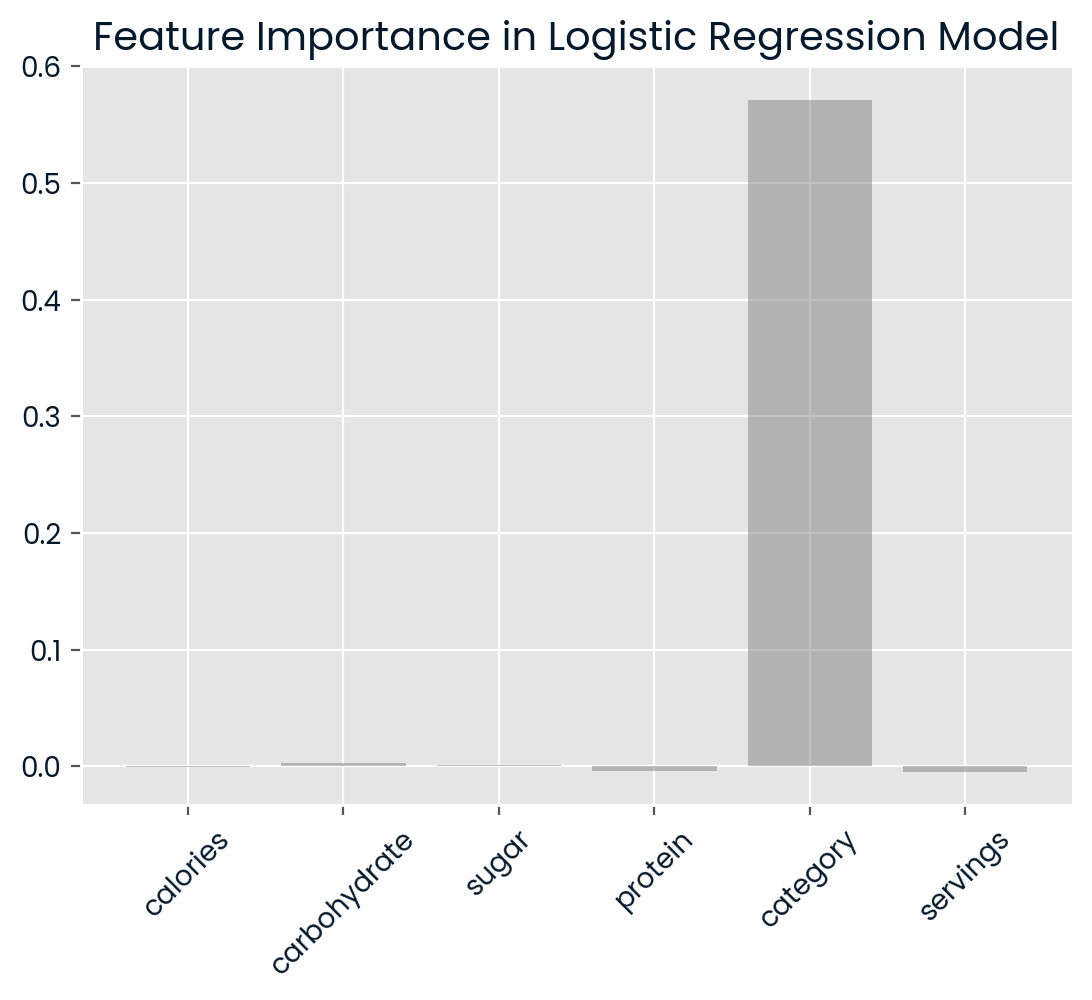

In [38]:
resultdict = {}
for i in range(len(X.columns)):
    resultdict[X.columns[i]] = logist.coef_[0][i]
    
plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5,color='gray')
plt.xticks(rotation=45)
plt.title('Feature Importance in Logistic Regression Model');


## Decision Tree Classification Model

In [39]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [40]:
y_score = dt.predict_proba(X_test)[:, 1]
y_pred = dt.predict(X_test)
print('DecisionTreeClassifier precision_score: ',precision_score(y_test, y_pred))
print('DecisionTreeClassifier roc_auc_score:', roc_auc_score(y_test, y_score))

DecisionTreeClassifier precision_score:  0.7786885245901639
DecisionTreeClassifier roc_auc_score: 0.7131019387116948


### Finding the best parameter for Decision Tree Classification Model

Best max_depth is: 3 
Testing precision is: 0.8125


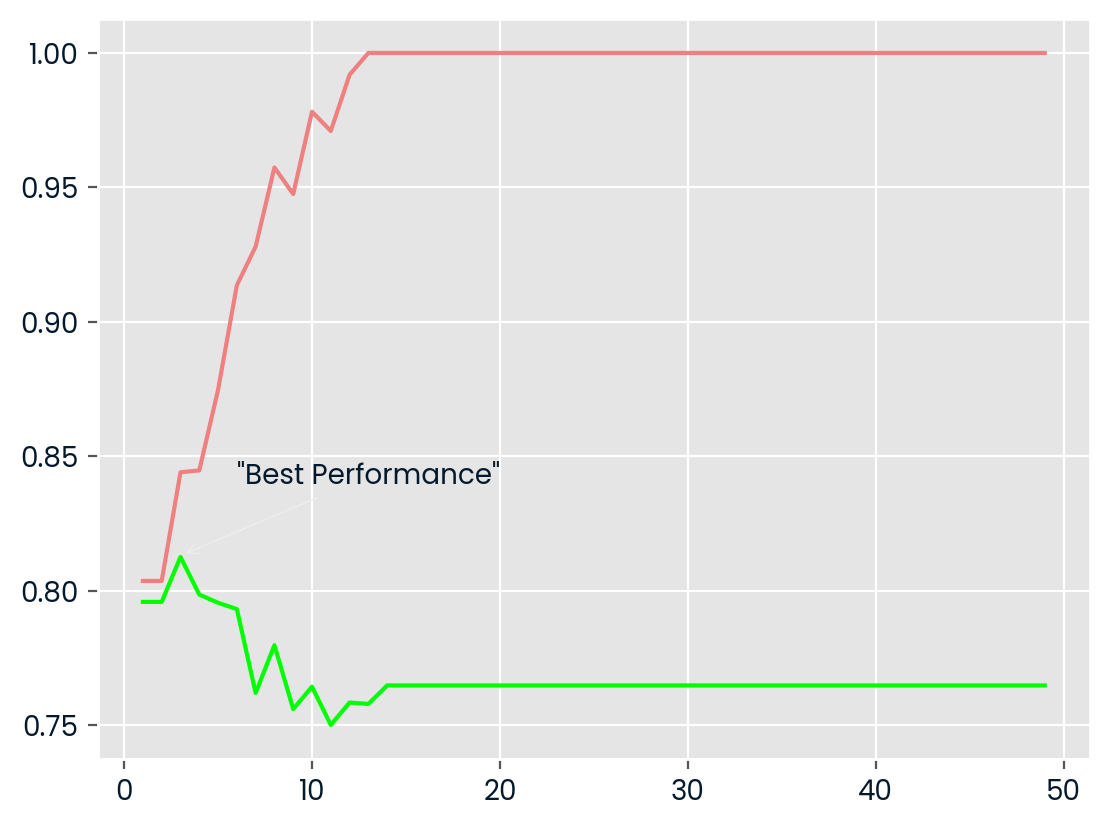

In [41]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    dt = DecisionTreeClassifier(max_depth=i,random_state=42)
    dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    train_score.append(precision_score(y_train, dt.predict(X_train)))
    test_score.append(precision_score(y_test, y_pred))
    test_pair = (i, precision_score(y_test, y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training precision",color='lightcoral')
ax.plot(np.arange(1,50), test_score, label = "Testing precision",color='lime')
plt.annotate('"Best Performance"', xy=(3, 0.813), xytext=(6, 0.84), arrowprops=dict(arrowstyle='->'))

print(f'Best max_depth is: {max_pair[0]} \nTesting precision is: {max_pair[1]}')

## Performing the new model 

In [42]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [43]:
y_score = dt.predict_proba(X_test)[:, 1]
y_pred = dt.predict(X_test)
print('DecisionTreeClassifier precision_score: ',precision_score(y_test, y_pred))
print('DecisionTreeClassifier roc_auc_score:', roc_auc_score(y_test, y_score))

DecisionTreeClassifier precision_score:  0.8125
DecisionTreeClassifier roc_auc_score: 0.8585053158223891


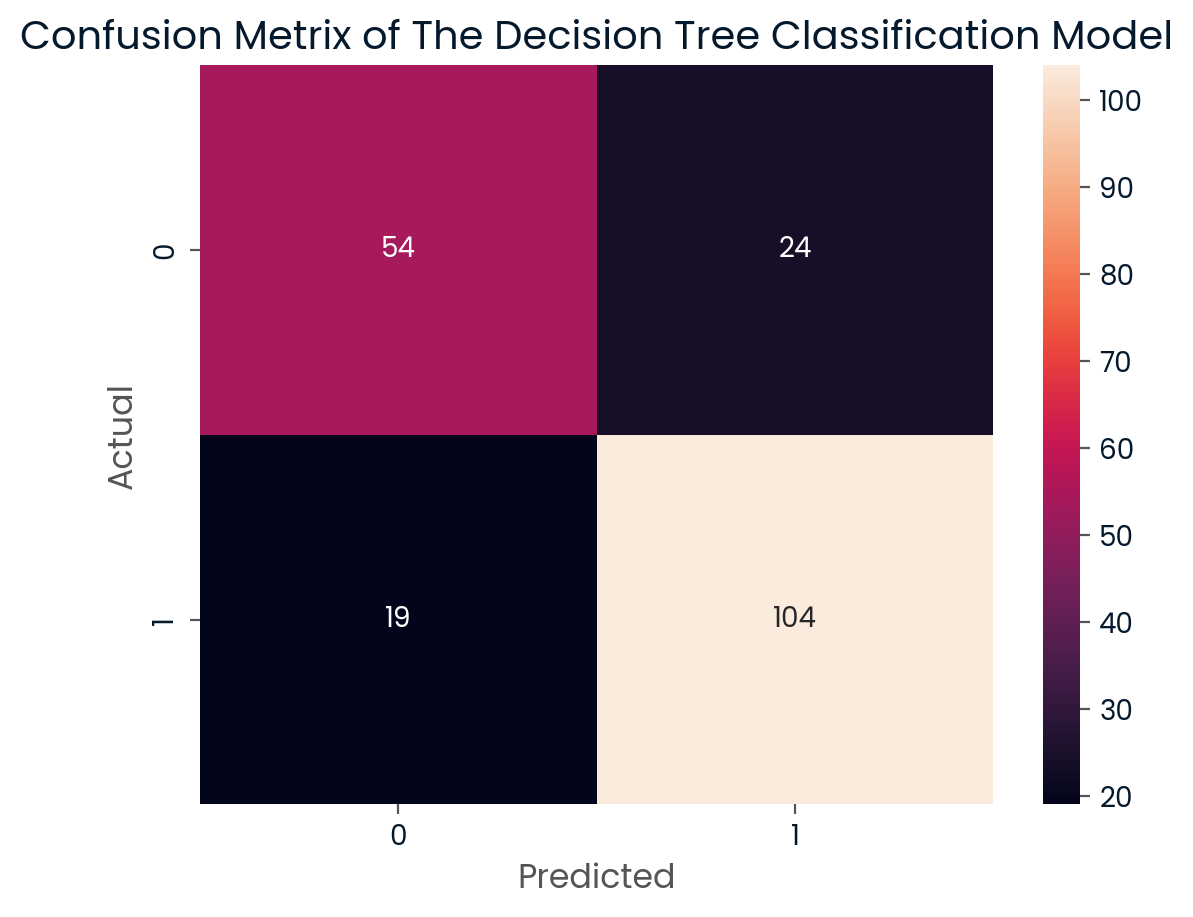

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Metrix of The Decision Tree Classification Model')
plt.show()

### Finding the feature importance

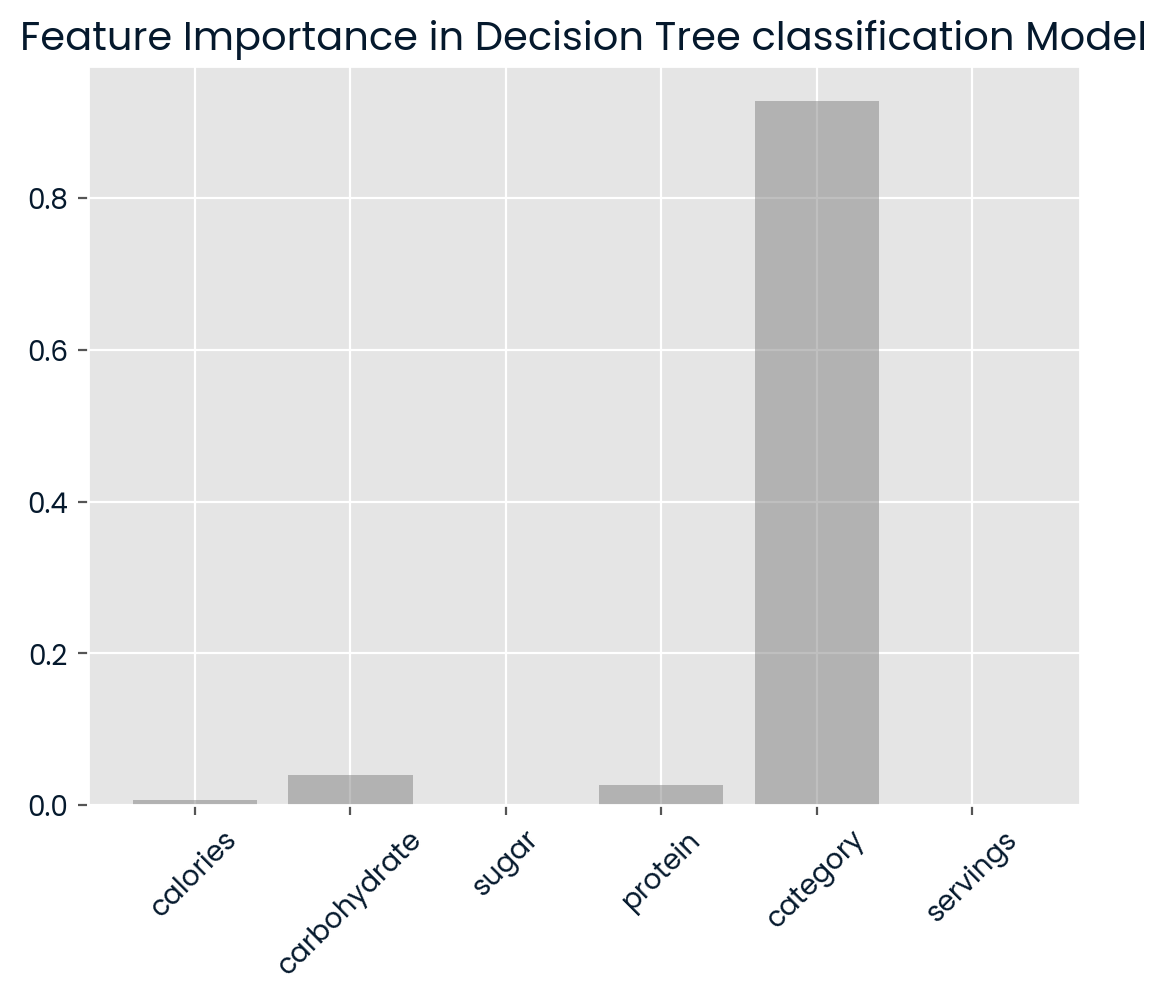

In [45]:
importance = dt.feature_importances_
new_column_names= X.columns
f_importance = {}
for i in range(len(new_column_names)):
     f_importance[new_column_names[i]] = importance[i]
        
plt.bar(f_importance.keys(),f_importance.values(),alpha=0.5,color='gray')
plt.xticks(rotation=45)
plt.title('Feature Importance in Decision Tree classification Model');

In [46]:
f_importance
cate_list = dict(zip(range(10),label_encoder.classes_))
label_encoder.classes_



array(['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks',
       'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'],
      dtype=object)

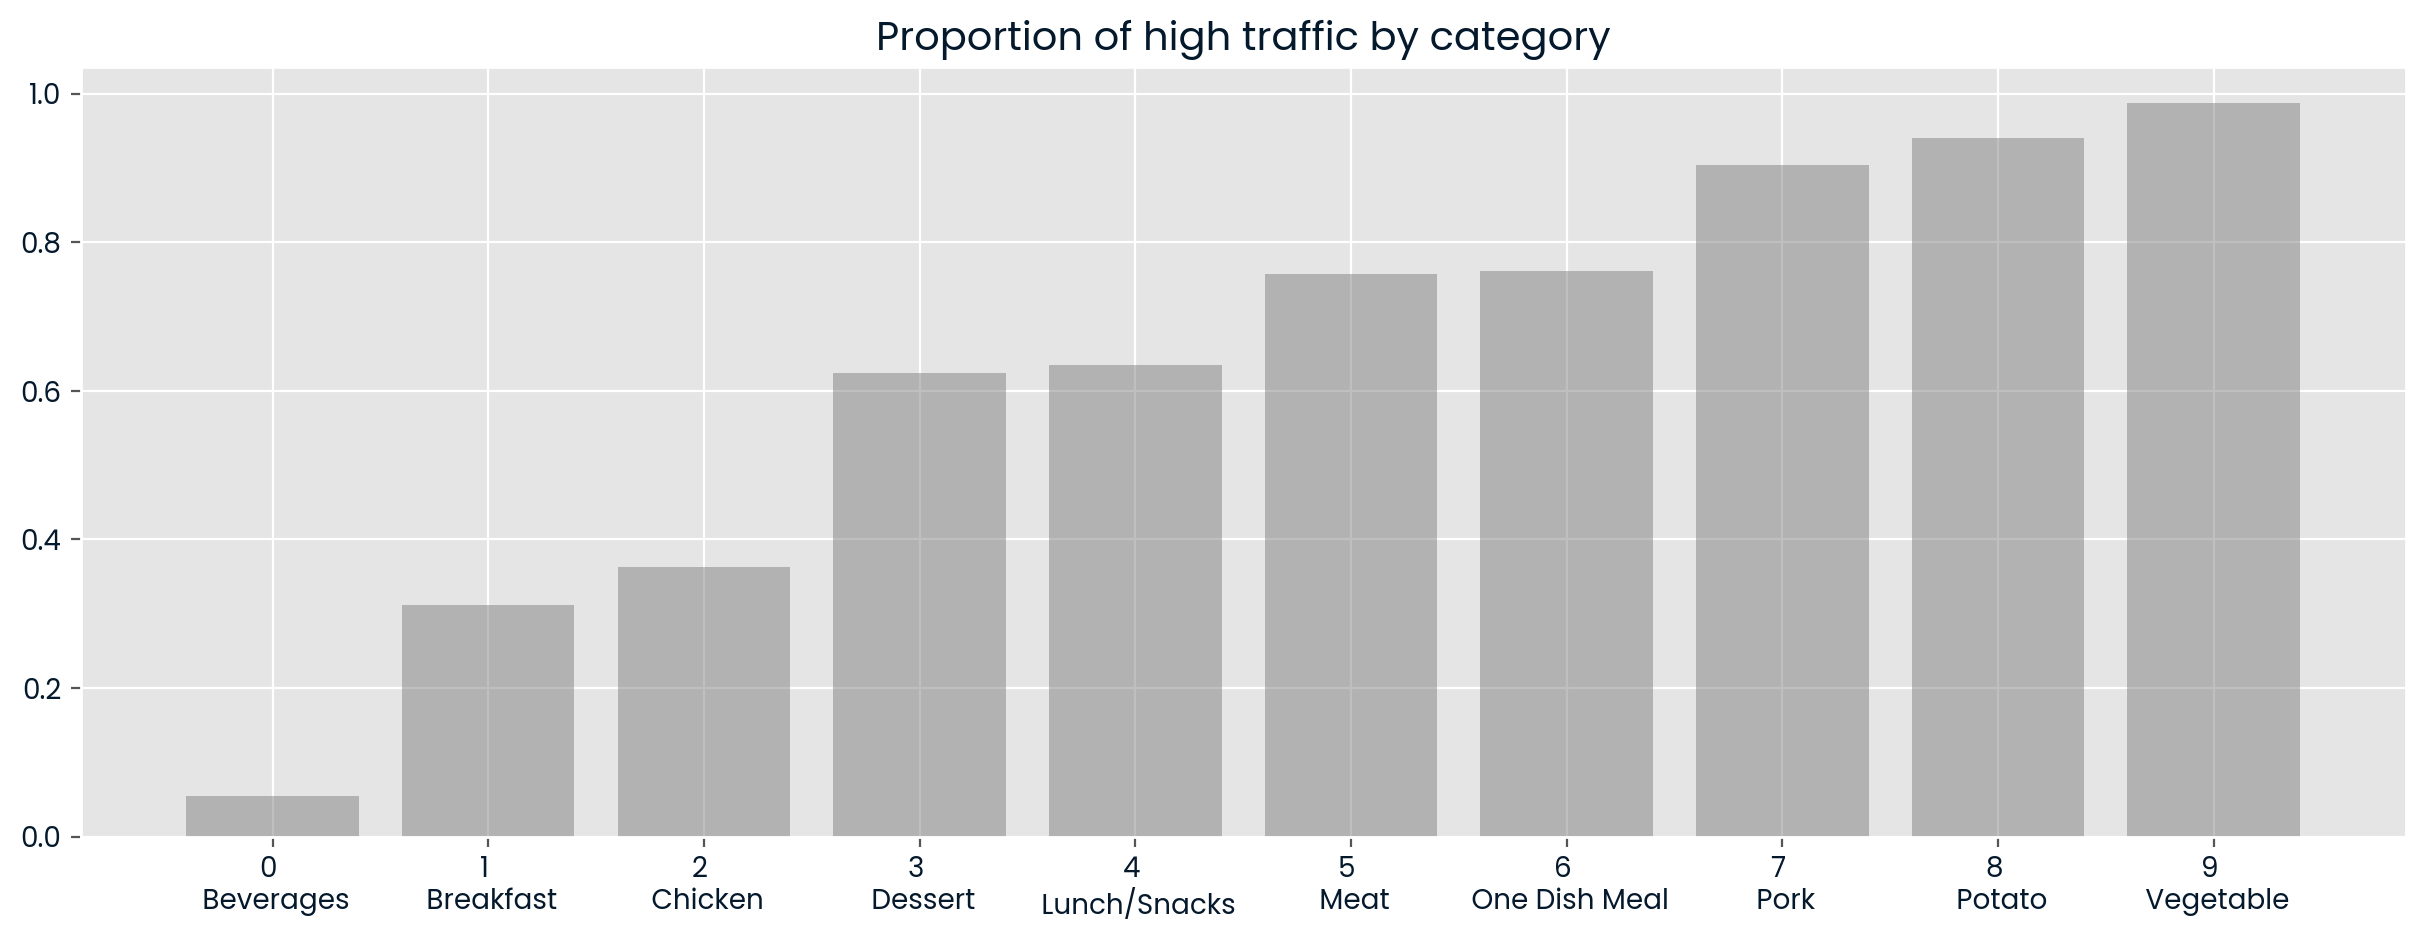

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
f_value = { f"{i} \n {cat}": df[df['category'] == i]['high_traffic'].mean() for i, cat in cate_list.items()}
plt.bar(f_value.keys(),f_value.values(),alpha=0.5,color='gray')
#plt.xticks(rotation=45)
plt.title('Proportion of high traffic by category')
plt.show();

## Results
The precision of the Logistic Regression, and the Decision Tree Classification model is 0.801 and 0.813, meaning the Logistic Regression model fits the features better. The AUC-ROC score of the Logistic Regression, and the Decision Tree Classification model is 0.864 and 0.858, meaning the Decision Tree Classification model has less error in predicting values and also both models are better than random prediction (>0.5).

## Evaluate by Business Criteria
The company wants to correctly predict high traffic recipes 80% of the time. Therefore, we would consider using precision metric that we have calculated already as a KPI to compare the two models. That is 0.801 and 0.813, or 80.1% and 81.3%, for Logistic Regression model and Decision Tree Classification.
The higher the score, the better the model performs.

To remind you, precision is the proportion of predicted positive cases, which is high traffic, that are actually correct.

## Recommendation
To choose a recipe to display on the homepage effectively, we can plan to deploy this **Decision Tree Classification** Model into production. By implementing this model, about 81.3% of probability of correctly predicting which recipe will lead to high traffic in the website. This will provide a better chance than random selection. I will recommend to deploy following steps to ensure the model can be deployed and improved regularly. 
1. Test the model in the recent month and run A/B Testing.
2. Identify and fix errors to improve the model.
3. Fully deploy the model and keep collect more data to improve the precision of the model.
